# 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mdtraj as md
#import mcg
import h5py
import pandas as pd
import sys
sys.path.append('../')
import matplotlib_config as cfg
import fnmatch
from matplotlib import cm
import pickle
from matplotlib.colors import PowerNorm

In [2]:
max_len = 100
max_force_eval = 1e10

In [3]:
step2us = 2e-9
burst = 1e5

In [4]:
AA = True

In [5]:
if AA == True:
    datafolders =['../AlwaysAcceptingClathrates/data_mu175_chain0_batch_0/', '../AlwaysAcceptingClathrates/data_mu175_chain0_batch_1/', '../AlwaysAcceptingClathrates/data_mu175_chain0_batch_2/']
else:
    datafolders =['../ClathrateTPS/data_mu175_chain1_batch_1/' , '../ClathrateTPS/data_mu175_chain1_batch_2/', '../ClathrateTPS/data_mu175_chain1_batch_3/']

gro_folder = 'gro_files'

In [6]:
if AA == True:
    chains = [[datafolders[0], datafolders[1], datafolders[2]]]
else:
    chains = [[datafolders[0], datafolders[1],  datafolders[2]]]

In [7]:
top_file = os.path.join(gro_folder, 'conf.gro')

In [8]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'trajectory_weights.npy'))[1:]
    
    # Load the log file
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    # Initialize weights column with zeros
    df['Weights'] = 0.0
    
    # Get successful rows
    successful_indices = df[df['Successful'] == True].index
    
    # Sanity check
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    # Assign weights to successful trajectories
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [9]:
# Dictionary to store all run data
run_data = {}

for datafolder in datafolders:
    print(datafolder)
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        # Skip non-directories and hidden folders
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        # Initialize entry for this run
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {},
            'trial_rej': {},
            'cages': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        # Process successful trials
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    trial_path = os.path.join(run_folder_path, succ_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    cutoff_mask = mcg_values >= 300
                    B_cutoff = int(frames[np.argmax(cutoff_mask)] / burst) if np.any(cutoff_mask) else None

                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values,
                        'B_cutoff': B_cutoff,
                        'file_path': os.path.join(run_folder_path, f'traj_{trial_num}.dcd')
                    }

                    parts = ['cages']
                    parts.extend(datafolder.split('_')[1:])
                    cagefolder = '_'.join(parts)


                    '''
                    times, _, Cages_512, Cages_62512, Cages_64512, Cages_4151062, _ = np.loadtxt(f'{cagefolder}/{run_folder}/traj_{trial_num}_stride_200_grade.txt', skiprows = 1, unpack = True)

                    run_data[datafolder][run_folder]['cages'][trial_num] = {
                    'frames': times,
                    '512': Cages_512,
                    '62512': Cages_62512,
                    '64512': Cages_64512,
                    '4151062': Cages_4151062
                    }
                    '''

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue
                
    
        
        # Process rejected trials
        for rej_file in os.listdir(run_folder_path):
            if rej_file.startswith('rejected_cv_trial_') and not rej_file.endswith('_0.txt'):
                try:
                    trial_num = int(rej_file.split('_')[3].split('.')[0])
                    trial_path = os.path.join(run_folder_path, rej_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    run_data[datafolder][run_folder]['trial_rej'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {rej_file} in {run_folder}: {e}")
                    continue
        


../AlwaysAcceptingClathrates/data_mu175_chain0_batch_0/
../AlwaysAcceptingClathrates/data_mu175_chain0_batch_1/
../AlwaysAcceptingClathrates/data_mu175_chain0_batch_2/


In [10]:
with open("successful_shooting_frames.txt", "w") as f:
    for dataset in run_data:
        for run in run_data[dataset]:
            f.write(f'{dataset}, {run}\n')
            df = run_data[dataset][run]['log']
            df_successful = df[df['Successful'] == True]

            o = df_successful['SP frame on old traj'].values
            n = df_successful['SP frame on new traj'].values
            if AA == True:
                directions = np.where(df_successful['Final state'].values == 'A', -1, 1)
            else:
                directions = df_successful['Shooting Direction'].values

            for i in range(len(df_successful)):
                f.write(f"{o[i]}\t{n[i]}\t{directions[i]}\n")

## Calculate frames (force evaluations per new acc traj)

In [11]:
all_force_eval_per_acc_path = []

all_path_lengths = []

acc_per_chain = []
rej_per_chain = []

for chain in chains:

    acc_per_run = []
    rej_per_run = []
    for run_idx in range(12):

        acc_in_a_row = 0
        rej_in_a_row = 0
    
        run = f'run_{run_idx}'
    
        full_lengths_required = 0 
        
        for dataset in chain:
    
            print(run)
            df = run_data[dataset][run]['log']
            #display(df)
            for trial in df['Trial'].values:
                trial_df = df[df['Trial'] == trial]
    
                if AA == True:
                    current_direction = np.where(trial_df['Final state'].values == 'A', -1, 1)
                else:
                    current_direction = trial_df['Shooting Direction'].values
                    
                o = trial_df['SP frame on old traj'].values
                n = trial_df['SP frame on new traj'].values
                L = trial_df['Full Path Length'].values * burst
    
                all_path_lengths.extend(L)
                
                if current_direction == -1:
                    current_length = int(n)
                elif current_direction == 1:
                    current_length = int(L - n)
                    
                full_lengths_required += current_length
    
                #print(full_lengths_required / 1e7)
    
                df.loc[df['Trial'] == trial, 'generated length'] = current_length
    
    
                if trial_df['Successful'].values == True:
                    acc_in_a_row += 1
                    all_force_eval_per_acc_path.append(full_lengths_required)
                    succ_trial = trial_df['Index'].values[0]
                    run_data[dataset][run]['index_succ'][succ_trial]['force_evaluations'] = full_lengths_required
                    df.loc[df['Trial'] == trial, 'force_evaluations'] = full_lengths_required
                    full_lengths_required = 0
                else:
                    rej_in_a_row += 1
            acc_per_run.append(acc_in_a_row)
            rej_per_run.append(rej_in_a_row)
            #display(df)
    acc_per_chain.append(acc_per_run)
    rej_per_chain.append(rej_per_run)

run_0
run_0
run_0
run_1
run_1
run_1
run_2
run_2
run_2
run_3
run_3
run_3
run_4
run_4
run_4
run_5
run_5
run_5
run_6
run_6
run_6
run_7
run_7
run_7
run_8
run_8
run_8
run_9
run_9
run_9
run_10
run_10
run_10
run_11
run_11
run_11


In [12]:
#print(acc_per_chain)
#print(rej_per_chain)

print(np.mean(acc_per_chain, axis = 1))

#print(np.mean(acc_per_chain))

print(acc_per_chain)

sum_acc = np.sum(acc_per_chain, axis = 0)
sum_rej = np.sum(rej_per_chain, axis = 0)

print(sum_acc)
#print(sum_rej)

print(np.mean(sum_acc))

sum_total = sum_acc.sum()
sum_total_rej = sum_rej.sum()

print(sum_total)
print(sum_total_rej)

print(sum_total/(sum_total_rej+sum_total_rej))

#print(np.mean(sum_acc))

[40.36111111]
[[28, 54, 90, 22, 39, 58, 17, 37, 43, 18, 38, 55, 27, 59, 95, 20, 39, 57, 20, 46, 71, 12, 26, 44, 12, 33, 45, 23, 47, 75, 19, 34, 51, 18, 33, 48]]
[28 54 90 22 39 58 17 37 43 18 38 55 27 59 95 20 39 57 20 46 71 12 26 44
 12 33 45 23 47 75 19 34 51 18 33 48]
40.361111111111114
1453
0
inf


/scratch_local/ipykernel_1761573/519132946.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  print(sum_total/(sum_total_rej+sum_total_rej))


In [13]:
if AA == True:
    np.save('data/avg_force_eval_per_acc_AA', np.mean(all_force_eval_per_acc_path))
    np.save('data/full_path_lengths_AA', all_path_lengths)
else:
    np.save('data/avg_force_eval_per_acc_1w', np.mean(all_force_eval_per_acc_path))
    np.save('data/full_path_lengths_1w', all_path_lengths)


In [14]:
def find_age_of_oldest_path(indices, directions, lengths, force_eval):
    '''
        Parameters:
            indices : list of tuples
                (old_index, new_index) are shooting point indices on the old and new path
            directions : list of int
                (+1 = forward shooting, -1 = backward shooting)
            first_path_length : int
                Length of the initial transition path (number of frames)

        Returns:
            AOPS_list : list of int
                Ages (in number of accepted paths) of the oldest path segment for each starting trajectory
            LOPS_list : list of lists
                Evolution of the oldest path segment lengths over successive accepted paths.
                Each sublist corresponds to one starting position in AOPS_list.
    '''

    LOPS_list = []  #lengths of oldest path segments
    force_eval_list = [] #force evaluations at specific path lengths 
    AOPS_list = []  #ages of oldest path segments
    
    # loop over all possible paths as starting paths
    for start in range(1, len(indices)):    #oldest path is only defined once another path has been accepted (so starts at idx 1)
        
        first_path_length = lengths[start - 1]
        
        # Setting up the first OPS after one new path has been generated
        _, first_path_n = indices[start]    #shooting point index on new path
        first_path_dir = directions[start]

        if first_path_dir == 1:
            SOPS = 0                    #SOPS (Start of oldest path segment) and EOPS (end of oldest path segment) are always defined in terms of the indices on the newest path
            EOPS = first_path_n
    
        if first_path_dir == -1:
            SOPS = first_path_n
            EOPS = first_path_length
    
        LOPS = EOPS - SOPS
        current_lengths = [LOPS]
        current_force_eval = [force_eval[start]]
        age = 1

        total_force_eval = [force_eval[start]]
    
    
        for idx, (o, n) in enumerate(indices[start + 1:], start = start + 1):       #(o, n) are sp indices on old/new path

    
            if directions[idx] == 1:        #easier version, no shift of indices necessary
                if n <= EOPS:
                    EOPS = n
                #otherwise the end stays where it was before
        
            elif directions[idx] == -1:     #indices need to be shifted
                shift = n - o
                if o >= SOPS:
                    SOPS = n
                    EOPS += shift
                else:                        # length stays the same but indices need to be shifted to fit current path 
                    SOPS += shift
                    EOPS += shift

    
            LOPS = EOPS - SOPS

            #when path dies
            if LOPS <= 0:
                AOPS_list.append(age)
                LOPS_list.append(current_lengths)
                force_eval_list.append(current_force_eval)
                break
                
            age += 1
            current_lengths.append(LOPS)
            #print(force_eval[idx])
            total_force_eval += force_eval[idx]
            current_force_eval.extend(total_force_eval)
            
        else:  # OPS survived all paths
            break  # Stop early since following starts will also survive

    return AOPS_list, LOPS_list, force_eval_list

In [15]:
ages_of_oldest_paths = []
lengths_of_oldest_path = []
force_evaluations_all = []

with open("successful_shooting_frames.txt", "w") as f:
    for chain in chains:
        for run_idx in range(11):
            run = f'run_{run_idx}'
            f.write(f'{dataset}, {run}\n')
    
            print(f'run idx {run_idx}')
    
            indices = []
            all_directions = []
            all_lengths = []
            all_force_eval = []
            
            for dataset in chain:
                
                df = run_data[dataset][run]['log']
                df_successful = df[df['Successful'] == True]
                weights = df_successful['Weights'].values
    
                o = df_successful['SP frame on old traj'].values
                n = df_successful['SP frame on new traj'].values

                force_evaluations = df_successful['force_evaluations'].values

                #print(f'force eval {force_evaluations}')
    
                #np.append(indices, np.column_stack((o, n)))
    
                indices.extend(zip(o, n))
    
                if AA == True:
                    directions = np.where(df_successful['Final state'].values == 'A', -1, 1)
                else:
                    directions = df_successful['Shooting Direction'].values
                    
                lengths = df_successful['Full Path Length'].values * burst
    
                all_directions.extend(directions)
                all_lengths.extend(lengths)
                all_force_eval.extend(force_evaluations)

    
            for i in range(len(df_successful)):
                f.write(f"{o[i]}\t{n[i]}\t{directions[i]}\t{lengths[i]}\n")
                
            #print(len(indices))
            #print(len(all_force_eval))
    
            AOPS, LFOPS, force_evaluations = find_age_of_oldest_path(indices, all_directions, all_lengths, all_force_eval)
            #print(AOPS)
            #print(LFOPS)
    
            #print(f'len {len(indices)}')
            #print(f'aops {AOPS} \nlfops {LFOPS}')
    
            ages_of_oldest_paths.extend(AOPS)
            lengths_of_oldest_path.extend(LFOPS)
            force_evaluations_all.extend(force_evaluations)

run idx 0
run idx 1
run idx 2
run idx 3
run idx 4
run idx 5
run idx 6
run idx 7
run idx 8
run idx 9
run idx 10


## Save lists/arrays

In [16]:
def pad_sequences(sequences, max_force_eval, target_length):
    """
    Pad sequences to the target_length with values increasing from their last element.
    
    Parameters:
        sequences (list of lists/tuples): Input sequences of numbers.
        target_length (int): Desired length for each sequence.
        
    Returns:
        list of lists: Padded sequences.
        
    Raises:
        ValueError: If any sequence is empty (no starting element for padding).
    """
    result = []
    for seq in sequences:
        lst = list(seq)  # Convert to list for mutable operations
        n = len(lst)
        
        # Handle empty sequences
        if n == 0:
            raise ValueError("Empty sequence encountered. Cannot pad without a starting element.")

        length_to_add = target_length - n 
        
        last_val = lst[-1]
        if n < target_length:
            padding = np.linspace(last_val, max_force_eval, num = length_to_add + 1)[1:]
            lst.extend(padding)
            
        result.append(lst)
    return np.array(result)

In [17]:
#max_len = max(len(sublist) for sublist in lengths_of_oldest_path)
L = [sublist + [0] * (max_len - len(sublist)) for sublist in lengths_of_oldest_path]

Ls_padded = np.array(L)

In [18]:
force_evaluations_padded = pad_sequences(force_evaluations_all, max_force_eval, max_len)

In [19]:
if AA == True:
    with open('data/LOPS_AA', 'wb') as f:
        pickle.dump(lengths_of_oldest_path, f)
    
    np.save('data/LOPS_padded_AA', Ls_padded)
    np.save('data/ages_AA', ages_of_oldest_paths)
    
else:
    with open('data/LOPS_1w', 'wb') as f:
        pickle.dump(lengths_of_oldest_path, f)
    
    np.save('data/LOPS_padded_1w', Ls_padded)
    np.save('data/ages_1w', ages_of_oldest_paths)

In [20]:
import matplotlib.colors as mcolors 
from cmap import Colormap

cm = Colormap('cmocean:dense')
mpl_cm = cm.to_mpl().reversed()

In [21]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.frameon': False
})


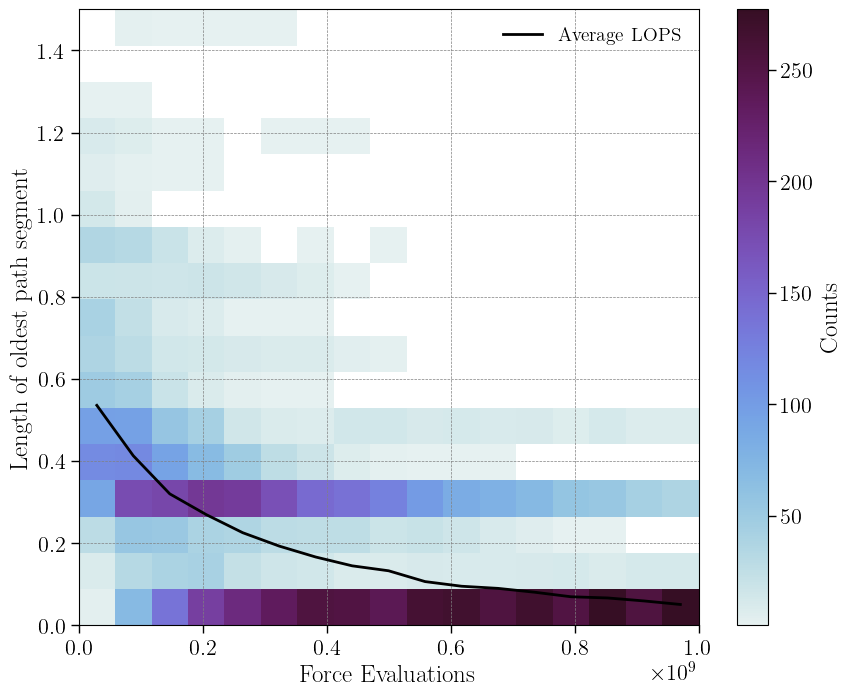

In [22]:
from scipy.stats import binned_statistic

flat_force_evals = [item for sublist in force_evaluations_padded for item in sublist]
flat_LFOPS = [item for sublist in Ls_padded for item in sublist]

flat_LFOPS_percent = [item / np.mean(all_path_lengths) for item in flat_LFOPS]

force_arr = np.array(flat_force_evals)
lfopps_arr = np.array(flat_LFOPS_percent)

num_bins = 17
#force_min, force_max = force_arr.min(), force_arr.max()
#lfopps_min, lfopps_max = lfopps_arr.min(), lfopps_arr.max()

force_min, force_max = 0, 1e9
lfopps_min, lfopps_max = 0, 1.5

force_bins = np.linspace(force_min, force_max, num_bins + 1)
lfopps_bins = np.linspace(lfopps_min, lfopps_max, num_bins + 1)

counts, xedges, yedges = np.histogram2d(force_arr, lfopps_arr, bins=[force_bins, lfopps_bins])
masked_counts = np.ma.masked_where(counts == 0, counts)

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

plt.figure(figsize=(10, 8))

X, Y = np.meshgrid(xedges, yedges)

plt.pcolormesh(X, Y, masked_counts.T, cmap=mpl_cm, shading='auto')
plt.colorbar(label='Counts')
plt.xlabel('Force Evaluations')
plt.ylabel('Length of oldest path segment')

bin_means, bin_edges, _ = binned_statistic(
    force_arr, 
    lfopps_arr, 
    statistic='mean', 
    bins=force_bins
)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

mask = ~np.isnan(bin_means)


plt.xlim(force_min, force_max)


plt.plot(bin_centers[mask], bin_means[mask], c = 'black', linewidth=2, label='Average LOPS')
plt.legend()

plt.show()

In [23]:
save_data = {
    'counts': counts,
    'xedges': xedges,
    'yedges': yedges,
    'force_bins': force_bins,
    'lfopps_bins': lfopps_bins,
    'bin_centers': bin_centers,
    'bin_means': bin_means,
    'mask': mask
}
if AA == True:
    np.savez('data/histogram_data_AA.npz', **save_data)
else:
    np.savez('data/histogram_data_1w.npz', **save_data)